<a href="https://colab.research.google.com/github/saumya-699/Data-Analytics-Process-and-Interpretation/blob/main/Data_Analytics_Process_and_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --------------------------
# 1. DATA LOADING & INSPECTION
# --------------------------



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/BIS/diabetes.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# =====================
# 2. DATA EXPLORATION
# =====================
# Basic statistics showing potential missing values (zeros)

In [ ]:
print("Initial Statistics:")
print(data.describe())

Initial Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   675.000000  675.000000     675.000000     675.000000  675.000000   
mean      3.758519  118.997037      72.020741      19.669630   61.856296   
std       3.251943   28.910637      10.813753      15.546395   78.607418   
min       0.000000   44.000000      44.000000       0.000000    0.000000   
25%       1.000000   99.000000      64.000000       0.000000    0.000000   
50%       3.000000  114.000000      72.000000      22.000000    0.000000   
75%       6.000000  136.000000      79.000000      32.000000  114.500000   
max      13.000000  198.000000     104.000000      60.000000  318.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  \
count  675.000000                675.000000  675.000000  675.000000   
mean    31.995111                  0.426796   32.472593    0.321481   
std      6.401033                  0.250690   10.926803    0.467391   
min     18.

In [ ]:
# Dataset structure information
print("\nData Structure:")
data.info()


Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               675 non-null    int64  
 1   Glucose                   675 non-null    float64
 2   BloodPressure             675 non-null    float64
 3   SkinThickness             675 non-null    float64
 4   Insulin                   675 non-null    float64
 5   BMI                       675 non-null    float64
 6   DiabetesPedigreeFunction  675 non-null    float64
 7   Age                       675 non-null    int64  
 8   Outcome                   675 non-null    int64  
 9   Cluster                   675 non-null    int32  
dtypes: float64(6), int32(1), int64(3)
memory usage: 50.2 KB


In [ ]:
# Check data dimensions
print(f"\nDataset Shape: {data.shape}")


Dataset Shape: (768, 9)


In [ ]:
# Value distribution check
print("\nValue Counts Analysis:")
print(data.value_counts())


Value Counts Analysis:
Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI   DiabetesPedigreeFunction  Age  Outcome
0            57       60             0              0        21.7  0.735                     67   0          1
             67       76             0              0        45.3  0.194                     46   0          1
5            103      108            37             0        39.2  0.305                     65   0          1
             104      74             0              0        28.8  0.153                     48   0          1
             105      72             29             325      36.9  0.159                     28   0          1
                                                                                                            ..
2            84       50             23             76       30.4  0.968                     21   0          1
             85       65             0              0        39.6  0.930                     

In [ ]:
# Column names verification
print("\nColumns:", data.columns.tolist())



Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [ ]:
# Missing values check (explicit nulls)
print("\nExplicit Missing Values:")
print(data.isnull().sum())



Explicit Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# Check duplicates
print("\nDuplicate Check:")
print(data[data.duplicated()])


Duplicate Check:
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


In [ ]:
# =====================
# 3. DATA CLEANING
# =====================
# Handle biological zeros (implicit missing values)
# Median imputation for normally distributed features

In [ ]:
median_cols = ['Glucose', 'BloodPressure', 'BMI']
data[median_cols] = data[median_cols].replace(0, np.nan).fillna(data[median_cols].median())

In [ ]:
# KNN imputation for skewed features
from sklearn.impute import KNNImputer
knn_cols = ['SkinThickness', 'Insulin']
knn_imputer = KNNImputer(n_neighbors=5)
data[knn_cols] = knn_imputer.fit_transform(data[knn_cols])

In [ ]:
# Outlier removal using IQR method
def detect_outliers_iqr(data):
    outliers = []
    for col in data.select_dtypes(include=np.number):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers.extend(data[(data[col] < Q1-1.5*IQR) | (data[col] > Q3+1.5*IQR)].index)
    return data.drop(list(set(outliers)))

data = detect_outliers_iqr(data)
print(f"\nPost-cleaning shape: {data.shape}")

In [ ]:
# =====================
# 4. EXPLORATORY DATA ANALYSIS
# =====================
# Outcome distribution analysis

In [ ]:
plt.figure(figsize=(8,6))
outcome_count = data["Outcome"].value_counts()
plt.pie(outcome_count, labels=["Non-Diabetic","Diabetic"], autopct='%1.1f%%',
        startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Diabetes Distribution in Dataset")
plt.legend(title="Outcome")
plt.show()

In [ ]:
# Age comparison analysis
diabetic = data[data['Outcome']==1]
non_diabetic = data[data['Outcome']==0]

plt.figure(figsize=(8,6))
plt.bar(["Diabetic", "Non-Diabetic"],
        [diabetic['Age'].mean(), non_diabetic['Age'].mean()],
        color=['#ff9999', '#66b3ff'])
plt.title("Average Age Comparison")
plt.ylabel("Mean Age")
plt.grid(axis='y')
plt.show()

In [ ]:
# Scatterplot matrix for key relationships
sns.pairplot(data, vars=['Glucose', 'BMI', 'Age', 'Insulin'],
             hue='Outcome', palette='Set2')
plt.suptitle("Feature Relationships by Diabetes Status", y=1.02)
plt.show()

In [ ]:
# =====================
# 5. VISUALIZATIONS
# =====================

In [ ]:
# Histogram distributions
data.hist(figsize=(15,12), bins=20, color='#86bf91')
plt.suptitle("Feature Distributions", y=1.02)
plt.show()

In [ ]:
# Boxplot comparisons
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.boxplot(x='Outcome', y='Glucose', data=data, ax=ax[0])
sns.boxplot(x='Outcome', y='BMI', data=data, ax=ax[1])
ax[0].set_title("Glucose Distribution by Outcome")
ax[1].set_title("BMI Distribution by Outcome")
plt.tight_layout()
plt.show()

In [ ]:
# Heatmap for correlation analysis
plt.figure(figsize=(12,8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# =====================
# 6. PREDICTIVE MODELING
# =====================

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_curve,
                             auc)

In [ ]:
print("Initial Data Overview:")
print(data.describe())  # Reveals min values of 0 in biological features
data.info()             # Shows 768 entries with no nulls (but 0s need handling)
print("\nMissing Value Analysis:")
print((data == 0).sum())  # Quantify zeros per column


Initial Data Overview:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   675.000000  675.000000     675.000000     675.000000  675.000000   
mean      3.758519  118.997037      72.020741      19.669630   61.856296   
std       3.251943   28.910637      10.813753      15.546395   78.607418   
min       0.000000   44.000000      44.000000       0.000000    0.000000   
25%       1.000000   99.000000      64.000000       0.000000    0.000000   
50%       3.000000  114.000000      72.000000      22.000000    0.000000   
75%       6.000000  136.000000      79.000000      32.000000  114.500000   
max      13.000000  198.000000     104.000000      60.000000  318.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  \
count  675.000000                675.000000  675.000000  675.000000   
mean    31.995111                  0.426796   32.472593    0.321481   
std      6.401033                  0.250690   10.926803    0.467391   
min     

In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
data.shape

(768, 9)

In [ ]:
data.value_counts()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI   DiabetesPedigreeFunction  Age  Outcome
0            57       60             0              0        21.7  0.735                     67   0          1
             67       76             0              0        45.3  0.194                     46   0          1
5            103      108            37             0        39.2  0.305                     65   0          1
             104      74             0              0        28.8  0.153                     48   0          1
             105      72             29             325      36.9  0.159                     28   0          1
                                                                                                            ..
2            84       50             23             76       30.4  0.968                     21   0          1
             85       65             0              0        39.6  0.930                     27   0          1
             87       0              23             0        28.9  0.773                     25   0          1
                      58             16             52       32.7  0.166                     25   0          1
17           163      72             41             114      40.9  0.817                     47   1          1
Name: count, Length: 768, dtype: int64

In [ ]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
data[data.duplicated]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [ ]:
# so there is no null values however the Insulin column has a lot of missing values in 0 value.

In [ ]:
# Calculate the percentage of zero values for each column
zero_percentage = (data.eq(0).sum() / len(data)) * 100

# Print results
print("Percentage of zero values in each column:")
print(zero_percentage)


Percentage of zero values in each column:
Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                     65.104167
dtype: float64


In [ ]:
cols_median = ['Glucose', 'BloodPressure', 'BMI']
data[cols_median] = data[cols_median].replace(0, np.nan).fillna(data[cols_median].median())


In [ ]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

cols_knn = ['SkinThickness', 'Insulin']
data[cols_knn] = knn_imputer.fit_transform(data[cols_knn])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def detect_outliers_iqr(data):
    outliers_indices = []

    # Loop through each numerical column
    for col in data.select_dtypes(include=["float64", "int64"]).columns:
        Q1 = data[col].quantile(0.25)  # First quartile
        Q3 = data[col].quantile(0.75)  # Third quartile

        IQR = Q3 - Q1  # Interquartile range

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR  # Corrected upper bound

        # Identify outliers
        outliers_in_col = data[(data[col] < lower_bound) | (data[col] > upper_bound)]  # Fixed condition

        outliers_indices.extend(list(outliers_in_col.index))  # Collect outlier indices

    # Remove duplicate indices
    outliers_indices = list(set(outliers_indices))

    # Remove the outliers from the original data
    data.drop(outliers_indices, inplace=True)  # Directly modify 'data' by removing outliers
    data.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows

# Assuming 'data' is your original dataframe
detect_outliers_iqr(data)  # Detect and remove outliers directly in 'data'

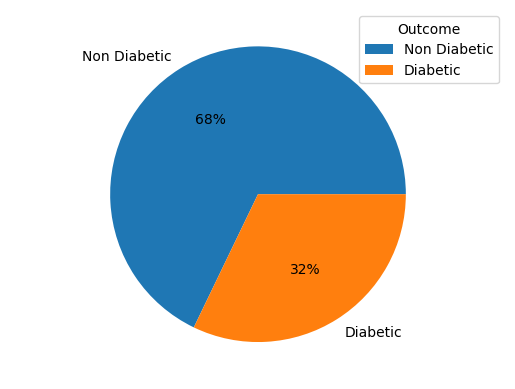

In [ ]:
# Let's see the difference between the people who has diabetes or not
outcome_count = data["Outcome"].value_counts()
outcome_count
plt.axis("equal")
plt.pie(outcome_count, labels = ["Non Diabetic","Diabetic"],autopct='%0.0f%%')
plt.legend(title="Outcome")
plt.show()

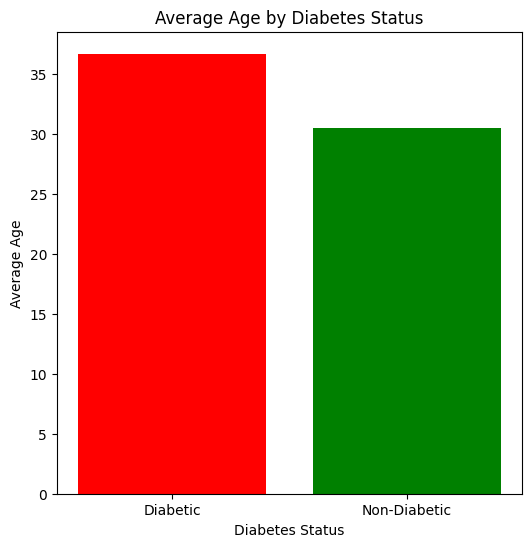

In [ ]:
# This chart represent the differance in the mean age between Diabetic and non-Diabetic patients
diabetic_patients = data[data['Outcome']==1]
nondiabetic_patients = data[data['Outcome']==0]

avg_DP = diabetic_patients['Age'].mean()
avg_nonDP = nondiabetic_patients['Age'].mean()

plt.figure(figsize=(6, 6))
plt.bar(["Diabetic", "Non-Diabetic"], [avg_DP, avg_nonDP], color=['red', 'green'])
plt.xlabel("Diabetes Status")
plt.ylabel("Average Age")
plt.title("Average Age by Diabetes Status")
plt.show()

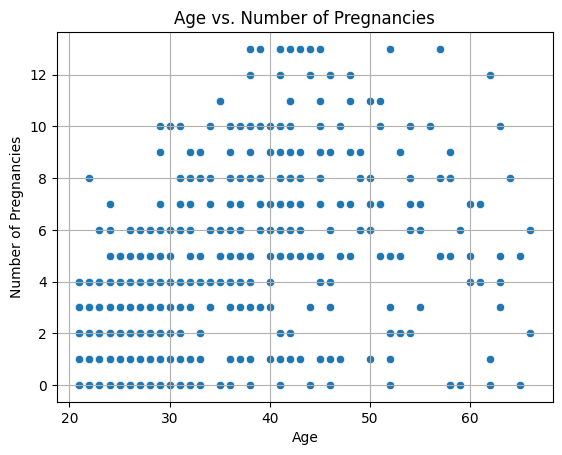

In [ ]:
# This chart represent the correlation between age and number of pregnancies
sns.scatterplot(x="Age", y="Pregnancies", data=data)
plt.xlabel("Age")
plt.ylabel("Number of Pregnancies")
plt.title("Age vs. Number of Pregnancies")
plt.grid(True)
plt.show()

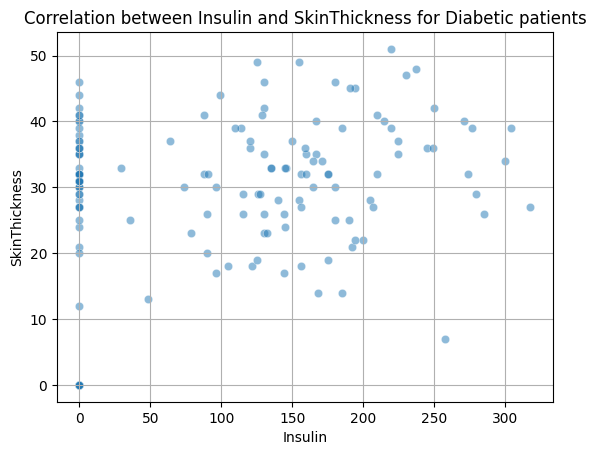

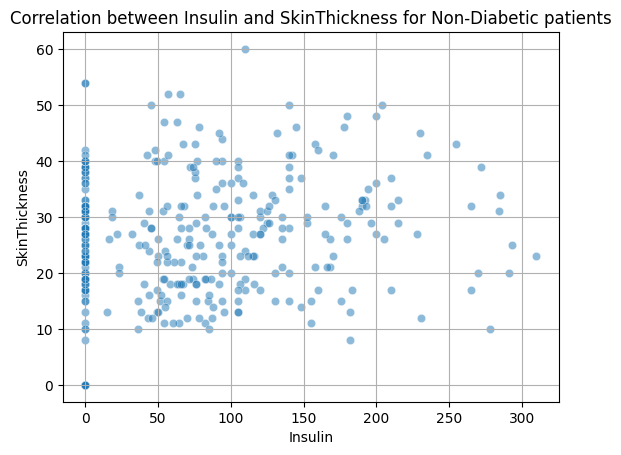

In [ ]:
# Filter for diabetic and non-diabetic groups
diabetic = data[data["Outcome"] == 1]
non_diabetic = data[data["Outcome"] == 0]

# Scatterplot for diabetic patients
sns.scatterplot(x="Insulin", y="SkinThickness", data=diabetic, alpha=0.5)
plt.xlabel("Insulin")
plt.ylabel("SkinThickness")
plt.title("Correlation between Insulin and SkinThickness for Diabetic patients")
plt.grid(True)
plt.show()

# Scatterplot for non-diabetic patients
sns.scatterplot(x="Insulin", y="SkinThickness", data=non_diabetic, alpha=0.5)
plt.xlabel("Insulin")
plt.ylabel("SkinThickness")
plt.title("Correlation between Insulin and SkinThickness for Non-Diabetic patients")
plt.grid(True)
plt.show()


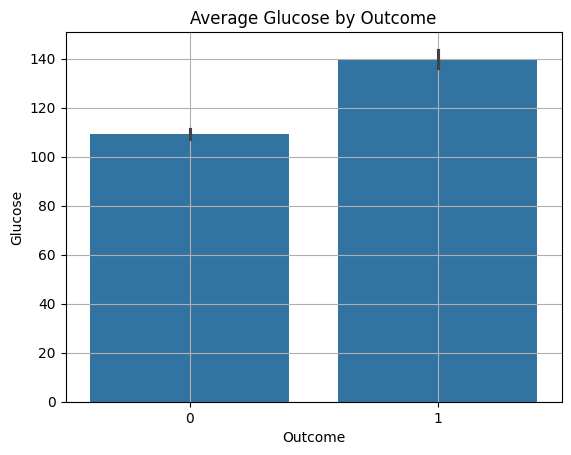

In [ ]:
sns.barplot(x="Outcome", y="Glucose", data=data)
plt.xlabel("Outcome")
plt.ylabel("Glucose")
plt.title("Average Glucose by Outcome")
plt.grid(True)
plt.show()

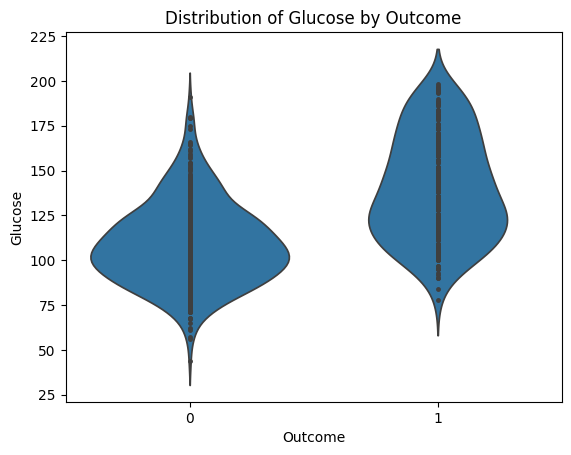

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot of Glucose distribution based on Outcome
sns.violinplot(x="Outcome", y="Glucose", data=data, inner="point")  # or inner="stick"

plt.xlabel("Outcome")
plt.ylabel("Glucose")
plt.title("Distribution of Glucose by Outcome")

plt.show()


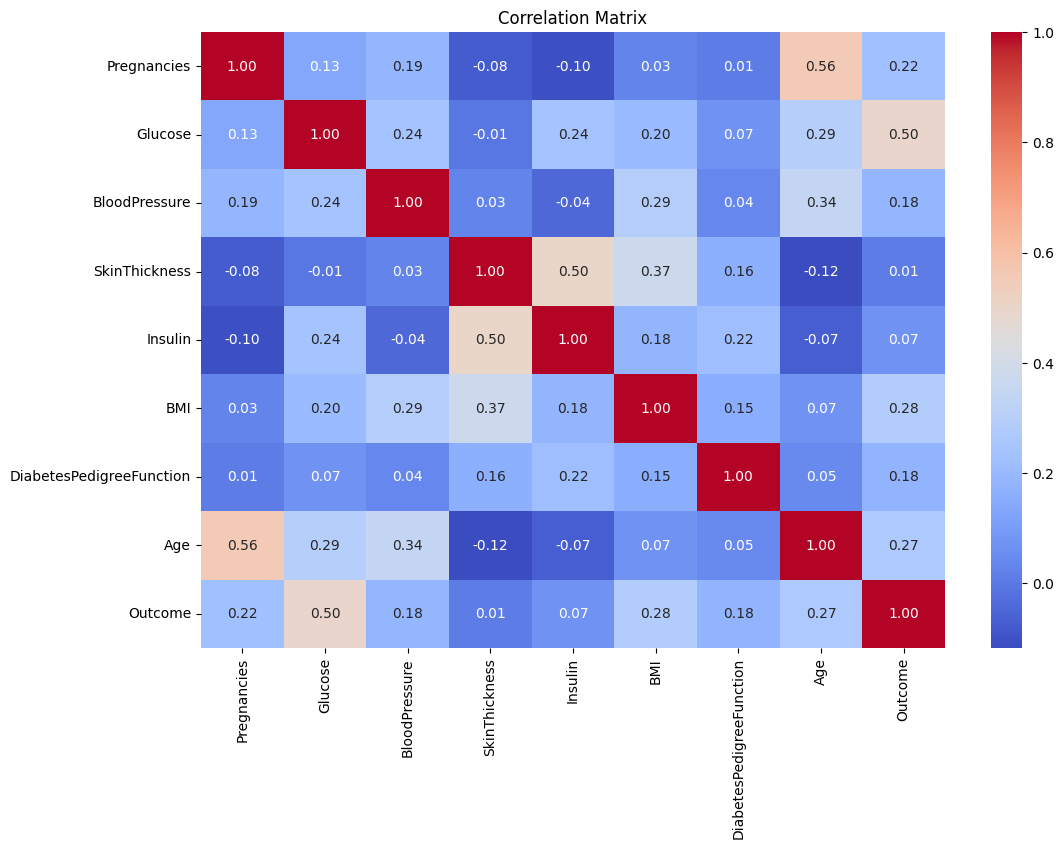

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

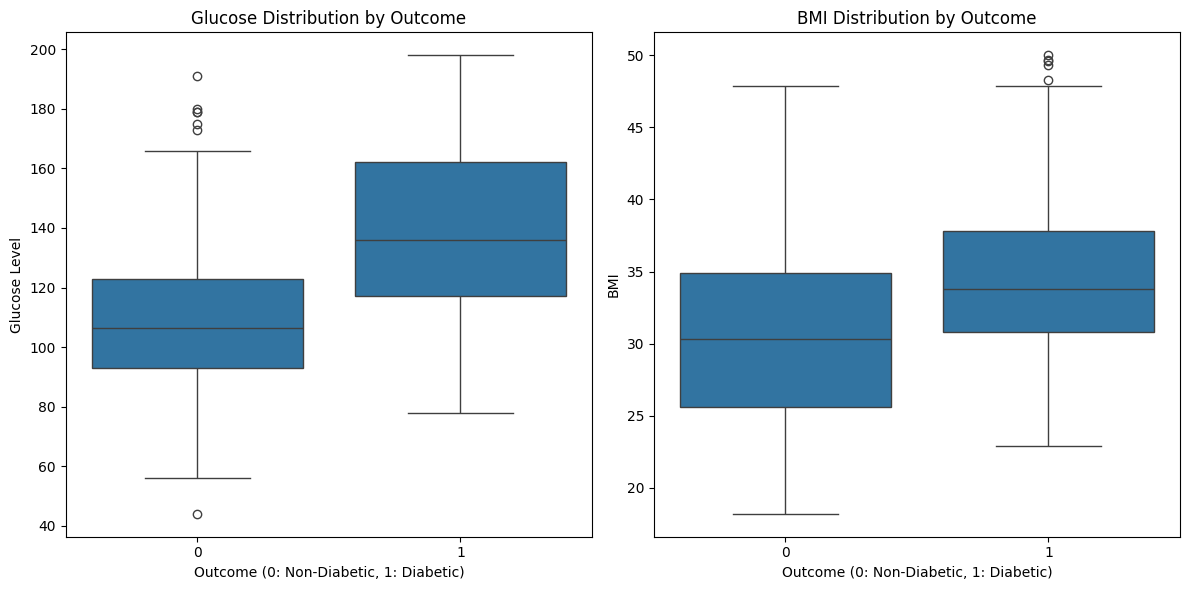

In [ ]:
# Boxplots for Glucose and BMI split by Outcome
plt.figure(figsize=(12, 6))

# Glucose
plt.subplot(1, 2, 1)
sns.boxplot(x='Outcome', y='Glucose', data=data)
plt.title('Glucose Distribution by Outcome')
plt.xlabel('Outcome (0: Non-Diabetic, 1: Diabetic)')
plt.ylabel('Glucose Level')

# BMI
plt.subplot(1, 2, 2)
sns.boxplot(x='Outcome', y='BMI', data=data)
plt.title('BMI Distribution by Outcome')
plt.xlabel('Outcome (0: Non-Diabetic, 1: Diabetic)')
plt.ylabel('BMI')

plt.tight_layout()
plt.show()

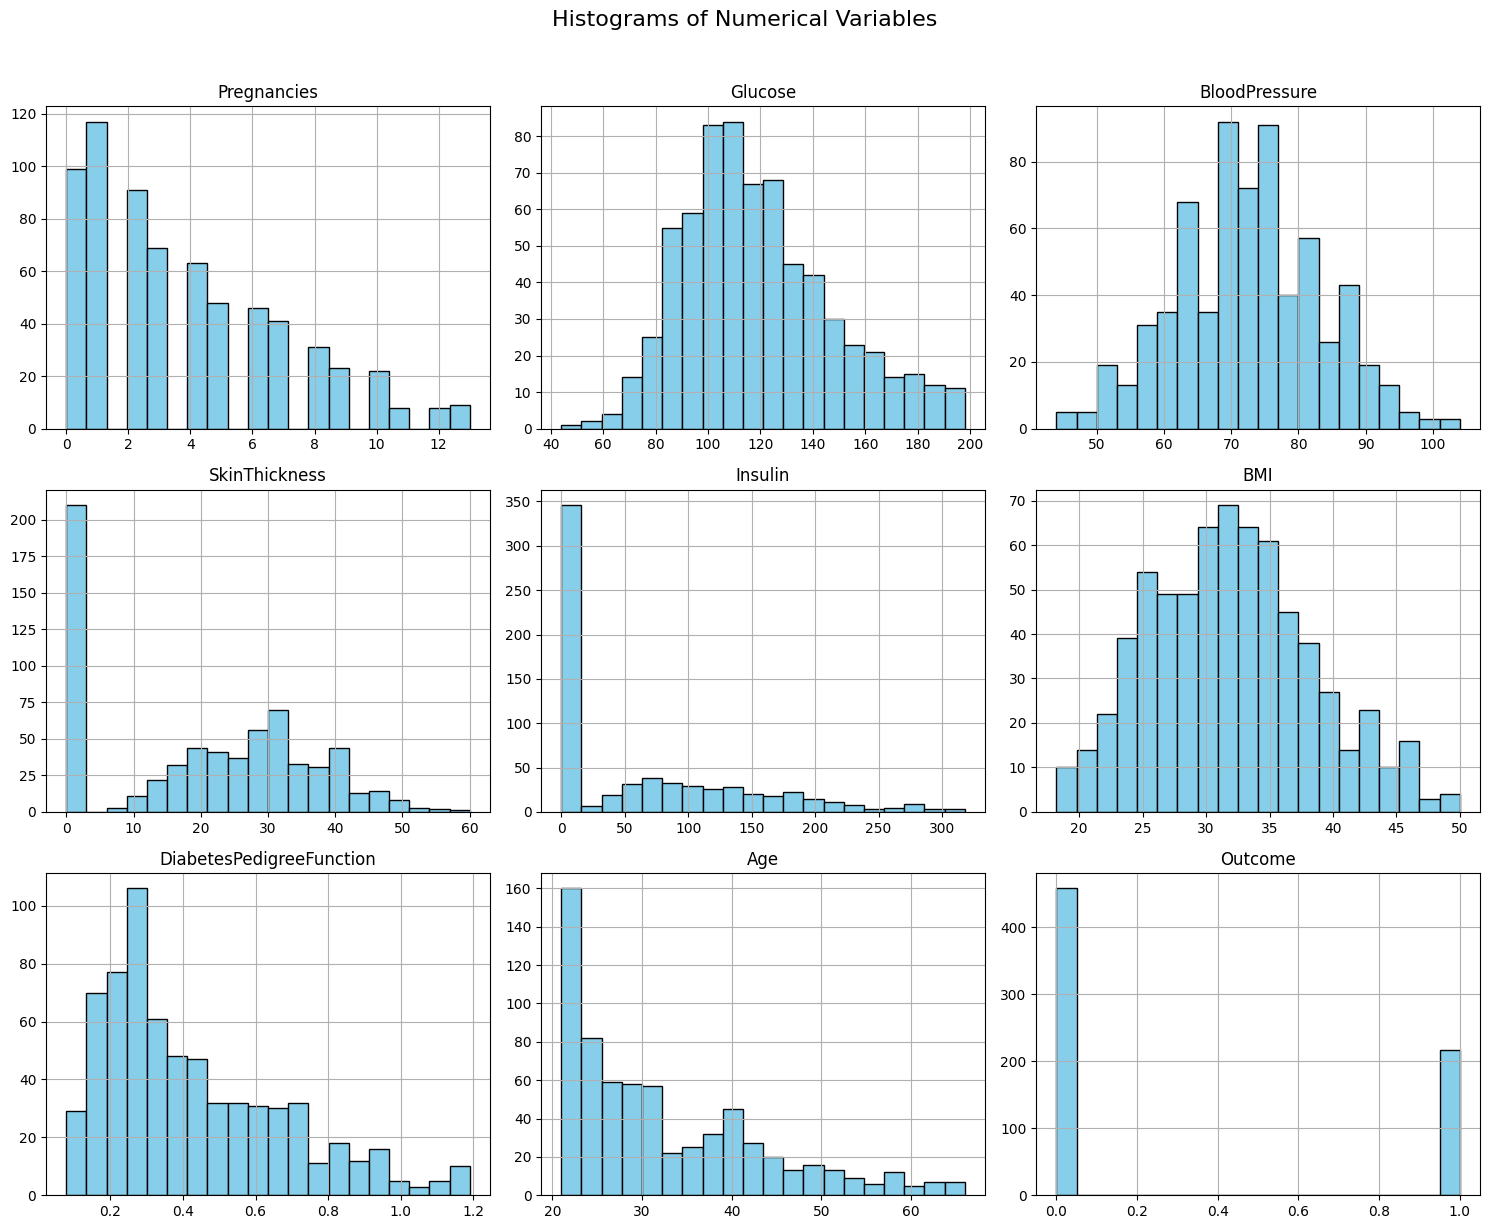

In [ ]:
# Histograms for all numerical variables
data.hist(figsize=(15, 12), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Variables', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

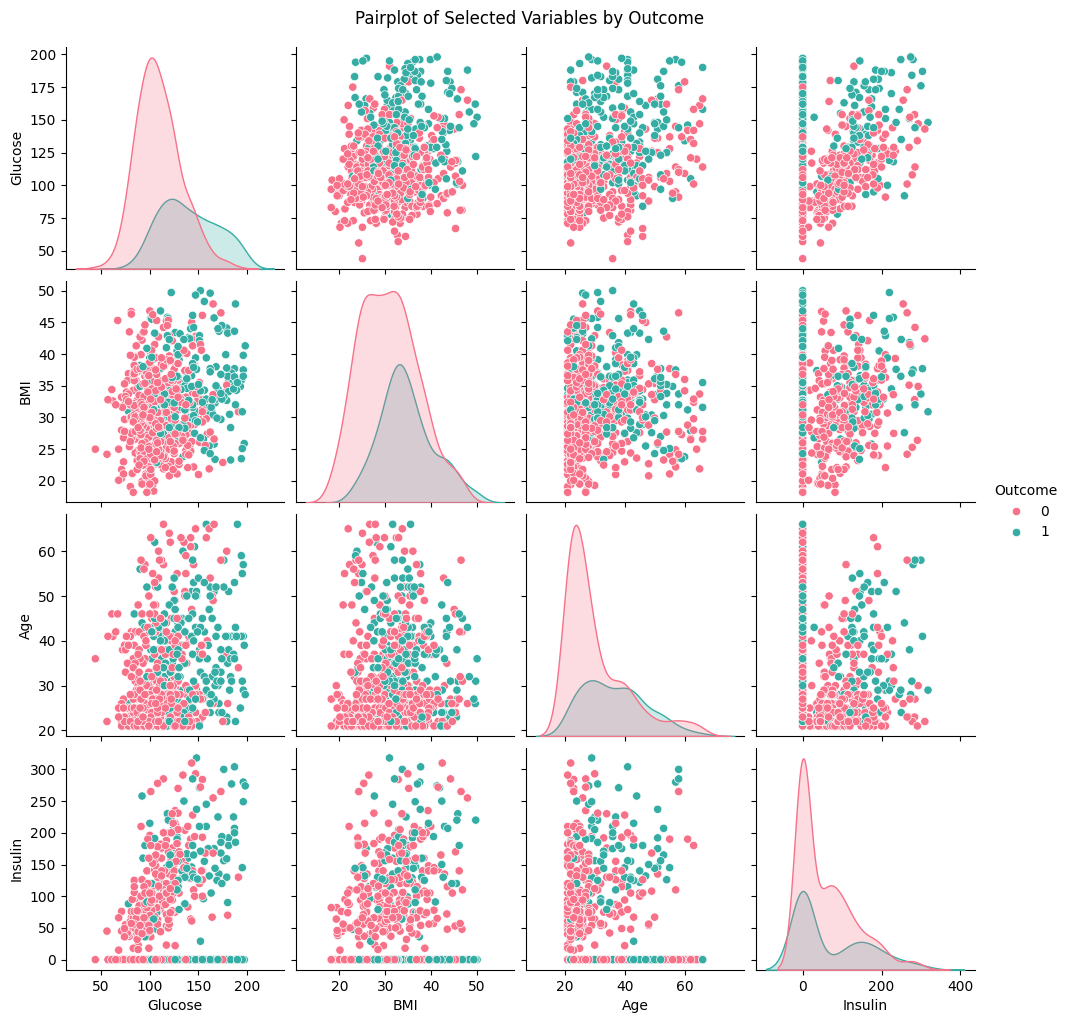

In [ ]:
# Pairplot for selected variables colored by Outcome
sns.pairplot(data, vars=['Glucose', 'BMI', 'Age', 'Insulin'], hue='Outcome', diag_kind='kde', palette='husl')
plt.suptitle('Pairplot of Selected Variables by Outcome', y=1.02)
plt.show()

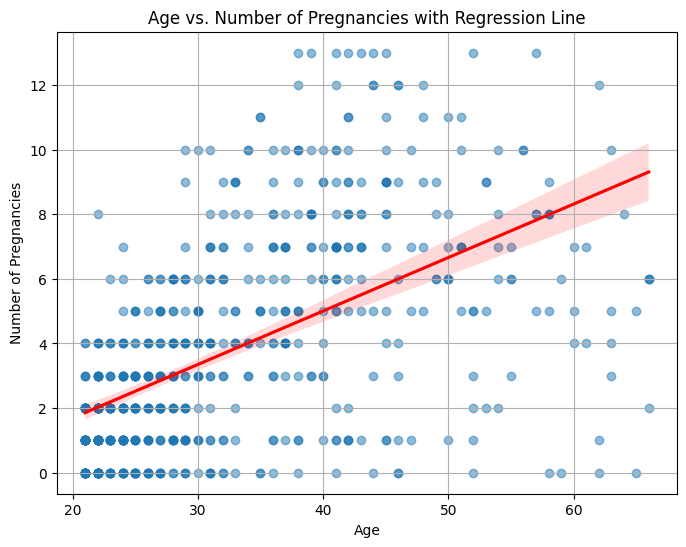

In [ ]:
# Enhanced scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Age', y='Pregnancies', data=data, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Age vs. Number of Pregnancies with Regression Line')
plt.xlabel('Age')
plt.ylabel('Number of Pregnancies')
plt.grid(True)
plt.show()

<ipython-input-29-4f9ca087cfe1>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Outcome'] == 0]['Glucose'], label='Non-Diabetic', shade=True)
<ipython-input-29-4f9ca087cfe1>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Outcome'] == 1]['Glucose'], label='Diabetic', shade=True)
<ipython-input-29-4f9ca087cfe1>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Outcome'] == 0]['BMI'], label='Non-Diabetic', shade=True)
<ipython-input-29-4f9ca087cfe1>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please 

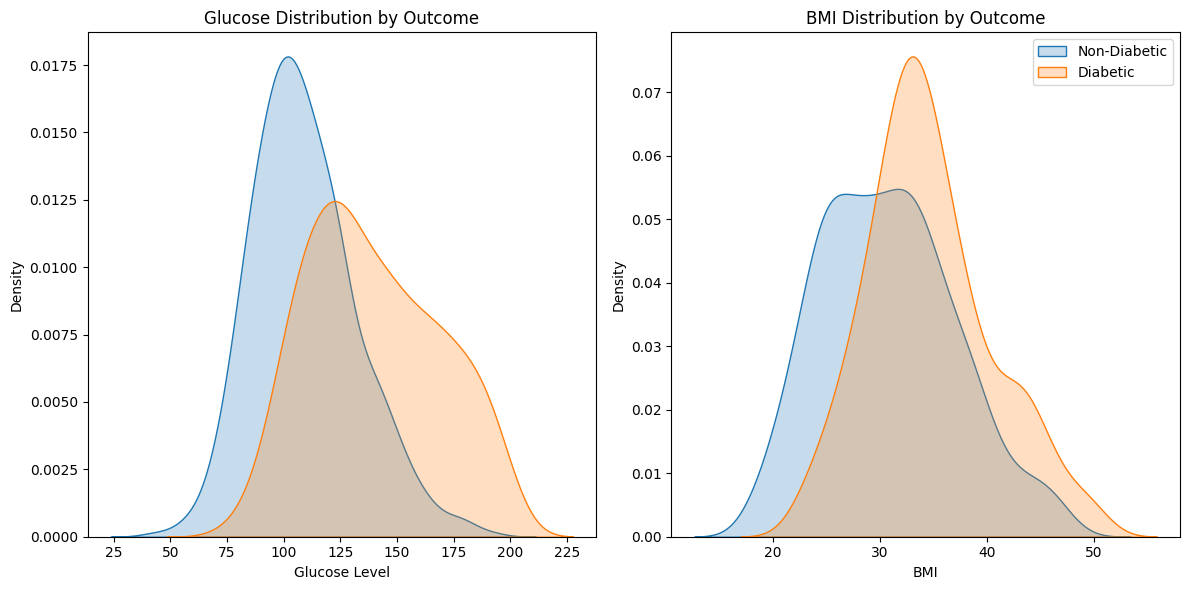

In [ ]:
# Density plots for Glucose and BMI
plt.figure(figsize=(12, 6))

# Glucose
plt.subplot(1, 2, 1)
sns.kdeplot(data[data['Outcome'] == 0]['Glucose'], label='Non-Diabetic', shade=True)
sns.kdeplot(data[data['Outcome'] == 1]['Glucose'], label='Diabetic', shade=True)
plt.title('Glucose Distribution by Outcome')
plt.xlabel('Glucose Level')
plt.ylabel('Density')

# BMI
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['Outcome'] == 0]['BMI'], label='Non-Diabetic', shade=True)
sns.kdeplot(data[data['Outcome'] == 1]['BMI'], label='Diabetic', shade=True)
plt.title('BMI Distribution by Outcome')
plt.xlabel('BMI')
plt.ylabel('Density')

plt.legend()
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       138
           1       0.77      0.51      0.61        65

    accuracy                           0.79       203
   macro avg       0.78      0.72      0.74       203
weighted avg       0.79      0.79      0.78       203



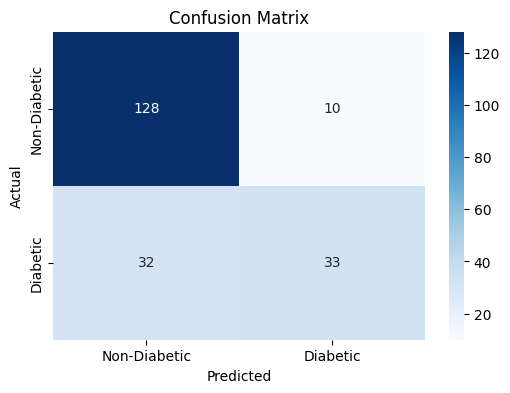

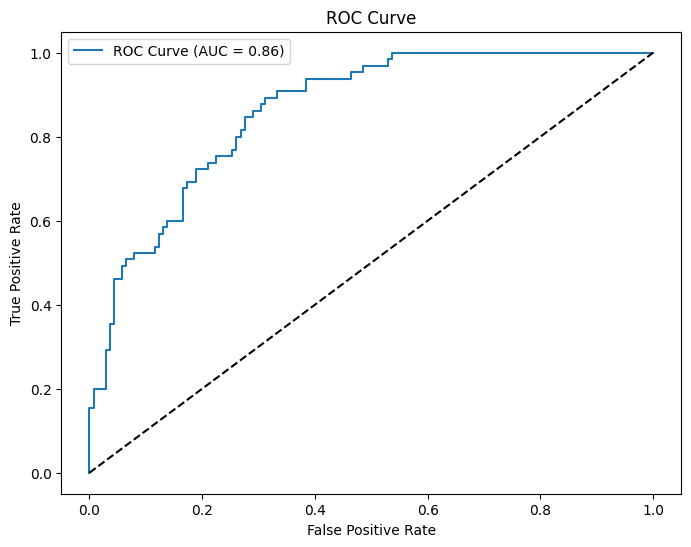

<ipython-input-38-d80e4a353ff0>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


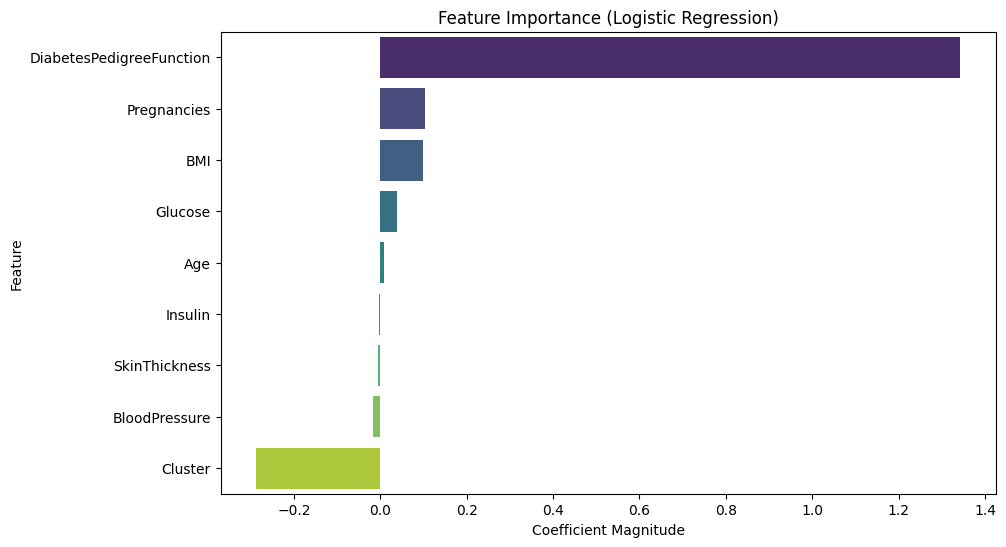

In [ ]:
#Predict diabetes (Outcome) and identify key risk factors.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load data (assuming `data` is already loaded)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature importance (coefficients)
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.show()

Decision Tree Accuracy: 0.7536945812807881
Random Forest Accuracy: 0.7931034482758621


<ipython-input-39-ae875586cfac>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


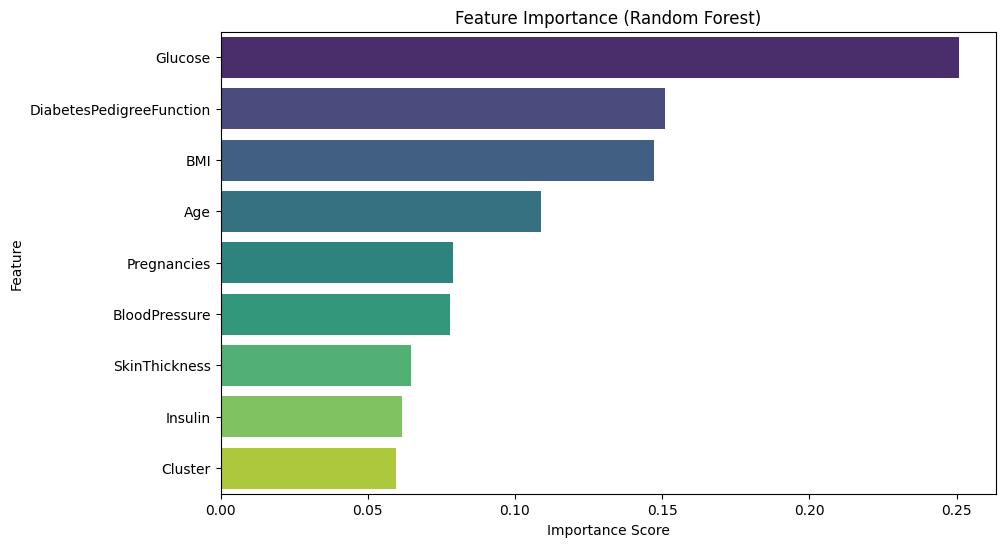

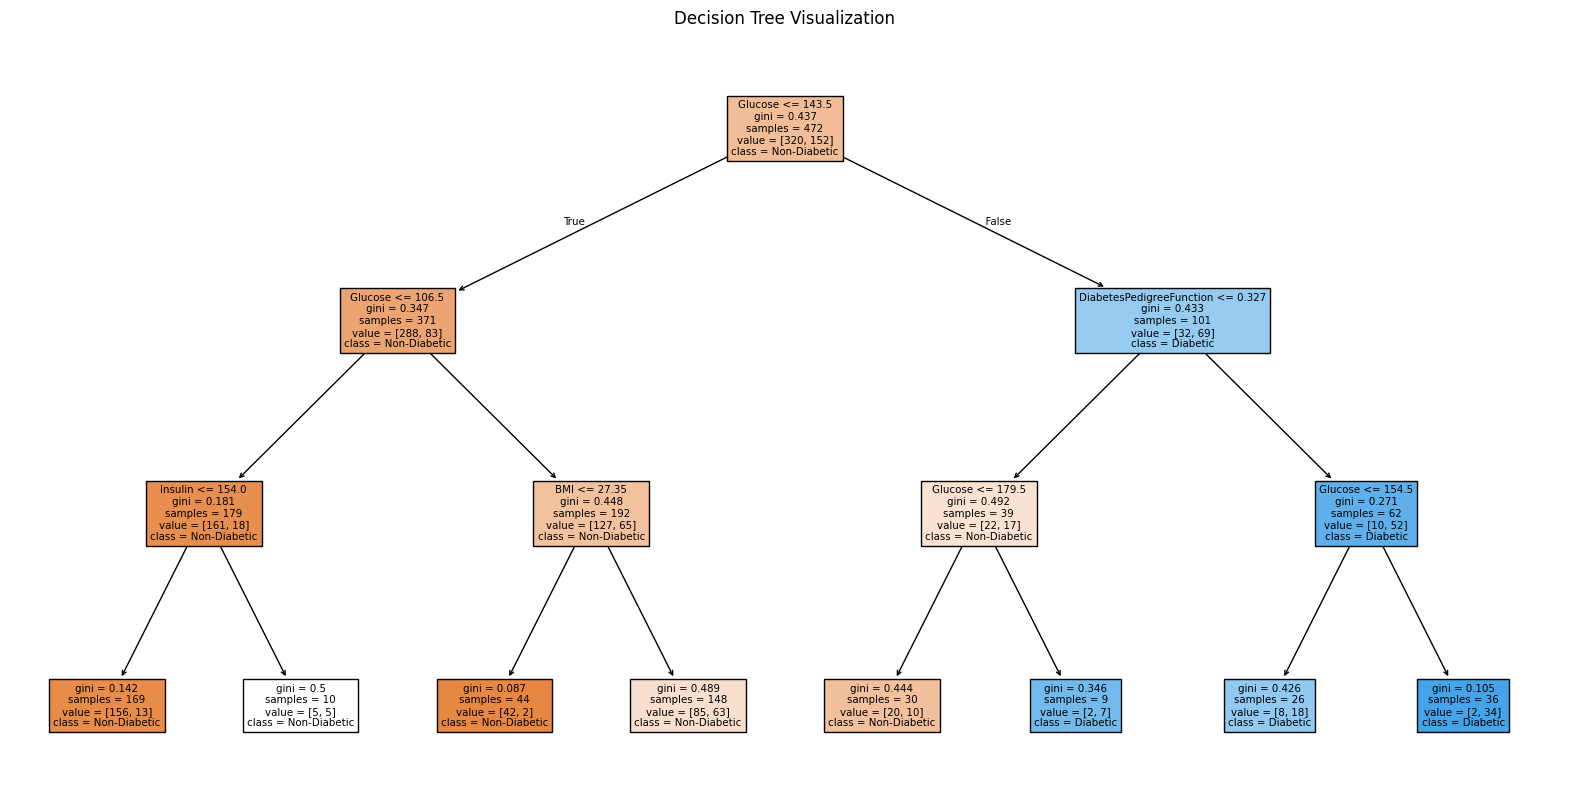

In [ ]:
#Non-linear classification with feature importance.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Decision Tree
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Feature importance (Random Forest)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Decision Tree visualization (requires graphviz)
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=['Non-Diabetic', 'Diabetic'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()

In [ ]:
#Support Vector Machine (SVM)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# SVM pipeline (with scaling)
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       138
           1       0.74      0.38      0.51        65

    accuracy                           0.76       203
   macro avg       0.75      0.66      0.67       203
weighted avg       0.75      0.76      0.73       203

